## 1. Importing Libraries

Before we begin working on our transfer learning task, we need to import several key libraries:

- **PyTorch (`torch`)**: The core deep learning library used to build and train models.
- **`torch.nn`**: A module that provides neural network layers and operations, which will be used to define and modify our model.
- **`torch.optim`**: A module that provides optimization algorithms, such as SGD and Adam, for training the model.
- **`torchvision.models`**: A collection of pre-trained models, including AlexNet, which we will be using for transfer learning.
- **`torchvision.transforms`**: A set of common transformations, such as resizing and converting images to tensors, to preprocess our image dataset.
- **`torchvision.datasets.ImageFolder`**: A utility to load and structure image datasets stored in folders.
- **`torch.utils.data.DataLoader`**: A utility to load data in batches and shuffle it for training.
- **`wandb`**: Weights & Biases, a tool for tracking and visualizing machine learning experiments.

In this block, we’re setting up all the necessary imports to get started with loading a pre-trained model and preparing our dataset.


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import wandb
import gradio as gr
import numpy as np

## 2. Initializing Weights & Biases (W&B) for Experiment Tracking

In this block, we initialize **Weights & Biases (W&B)** to track and log our experiment. W&B is a popular tool used in machine learning for tracking model performance, visualizing training progress, and organizing results.

- **`wandb.init()`**: This initializes the W&B project and sets the configuration for the experiment.
    - **`project`**: The name of the project on W&B. In this case, it’s called `"resnet18-transfer-learning-hamk"`, indicating that we will be using the ResNet18 model for transfer learning.
    - **`config`**: A dictionary that defines key parameters of our experiment:
        - **`epochs`**: The number of training epochs (in this case, 10).
        - **`batch_size`**: The size of each batch during training (set to 16).
        - **`learning_rate`**: The initial learning rate for the optimizer (set to 0.001).
        - **`architecture`**: The pre-trained model architecture we will use (ResNet18).
        - **`dataset`**: The name of the dataset (Rock Paper Scissors, abbreviated as "RPS").

By using W&B, we can easily monitor our model’s performance, visualize metrics such as loss and accuracy, and compare different runs.


In [70]:
# Initialize W&B and set up the project
wandb.init(project="resnet18-transfer-learning-hamk", config={
    "epochs": 10,
    "batch_size": 16,
    "learning_rate": 0.0001,
    "architecture": "ResNet18",
    "dataset": "tree_detection"
})

Train Accuracy,▁▄▅▅▇▆▇▆▇▇▇████████▇█
Train Loss,█▅▄▄▂▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▆▆▇█████████████
Validation Loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,100
Train Loss,0.00512
Validation Accuracy,96.07843
Validation Loss,0.04429


In [71]:
config = wandb.config

In [72]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. Preparing the Dataset and Data Loaders

In this block, we define the necessary transformations for our dataset, load the data, and create data loaders for training and validation.

### Transformations
- **`Compose()`**: We use `Compose` to apply a series of transformations to the images.
    - **`Resize((28, 28))`**: This resizes the images to a fixed size of 28x28 pixels, which is suitable for the model input.
    - **`ToTensor()`**: This converts the images into tensors, which are required by PyTorch for model training.

### Loading the Dataset
- **`ImageFolder()`**: This utility is used to load images stored in folder structures. Each folder corresponds to a class label, and the images are automatically labeled based on the folder names.
    - **`train_data`**: The training dataset is loaded from the `"rps"` directory, which contains images for Rock Paper Scissors.
    - **`val_data`**: The validation dataset is loaded from the `"rps-test-set"` directory.
    - **`train_data.classes`**: This prints out the class labels (Rock, Paper, Scissors) from the dataset.

### Data Loaders
- **`DataLoader()`**: This utility loads data in batches and shuffles it for training or validation.
    - **`train_loader`**: Loads the training dataset with a batch size of 16 and shuffles the data.
    - **`val_loader`**: Loads the validation dataset with a batch size of 16 but without shuffling.

The final lines of the block print the number of samples in both the training and validation sets. These data loaders will be used to feed data into the model during training.


In [73]:
# Transformations (from your lab)
transform = Compose([Resize((224, 224)), ToTensor()])

# Load the dataset
train_data = ImageFolder(root='train_data', transform=transform)
val_data = ImageFolder(root='val_data', transform=transform)
print('Classes:', train_data.classes)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Classes: ['birch', 'maple', 'pine', 'rowan', 'spruce']
Number of training samples: 280
Number of validation samples: 51


## 4. Loading a Pre-trained ResNet Model

In this block, we load the pre-trained **ResNet18** model, which is a popular deep learning architecture known for its residual connections that help avoid the vanishing gradient problem in deep networks.

- **`models.resnet18()`**: This function loads the **ResNet18** architecture from the **torchvision** library.
    - **`weights=models.ResNet18_Weights.DEFAULT`**: This specifies that we are using the pre-trained weights provided by **torchvision**. These weights are trained on a large-scale dataset like ImageNet, allowing us to benefit from a model that has already learned useful features.
- **`.to(device)`**: This moves the model to the specified device (usually a GPU or CPU). If a GPU is available, the model will run on it for faster computations.

By using this pre-trained model, we leverage the knowledge it has already learned and adapt it to our specific task (transfer learning).


In [74]:
# Load a pretrained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

In [75]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


## 5. Displaying the Model Summary

In this block, we use the **torchsummary** library to display a detailed summary of the **ResNet18** model architecture. This helps us understand the structure of the model and the number of parameters involved.

- **`summary(model, input_size=(3, 224, 224))`**: This function provides a layer-by-layer summary of the model architecture.
    - **Input size**: For ResNet18, the expected input size is a 3-channel image (RGB) with dimensions 224x224 pixels.

### Model Summary
- **Layer (type)**: Lists each layer in the model, such as convolutional layers, batch normalization, ReLU activations, and fully connected layers.
- **Output Shape**: Displays the shape of the output after each layer.
- **Param #**: Shows the number of parameters in each layer, including trainable parameters like weights and biases.

The model has approximately **11.7 million parameters**, all of which are trainable. This is a relatively small number compared to deeper models like ResNet50, making ResNet18 a good choice for transfer learning tasks with limited computational resources.

The summary provides the estimated memory usage for the input size, forward/backward passes, and the parameters, giving us a clear idea of the model's complexity and memory requirements.


In [76]:
# Display model summary (for an input size of (3, 224, 224) for ResNet)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [77]:
# Print model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 6. Modifying the Final Fully Connected Layer for Transfer Learning

In transfer learning, we often modify the final layer of a pre-trained model to adapt it to our specific task. In this case, we are fine-tuning the **ResNet18** model for the **Rock-Paper-Scissors** dataset, which has 3 output classes.

- **`model.fc = nn.Linear(512, 3)`**: 
    - The final fully connected (FC) layer of ResNet18 is originally designed for 1000 classes (as it was trained on ImageNet).
    - We replace the FC layer with a new `Linear` layer that has 512 input features (from the last layer of ResNet18) and 3 output features (corresponding to the 3 classes: Rock, Paper, and Scissors).
    - **`.to(device)`**: Moves the modified layer to the device (GPU or CPU).

By modifying this layer, we retain all the features learned by the pre-trained model and fine-tune the final layer to classify images into the 3 target categories.

- The following image is of AlexNet but the idea of Modifying the final layer is same

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/alexnet.png?raw=1)

*Source: Generated using Alexander Lenail’s [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author*

In [78]:
# Modify the final fully connected layer for transfer learning (assuming 3 classes for the Rock-Paper-Scissors dataset)
model.fc = nn.Linear(512, 5).to(device)

In [79]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 7. Defining the Training and Validation Loops

In this section, we define two key functions: one for training the model and one for validating its performance. These loops are fundamental to the transfer learning process, where the pre-trained model is fine-tuned on our specific dataset.

### Training Loop

The **`train()`** function handles the training process for one epoch, performing the following steps:

- **`model.train()`**: Sets the model to training mode, enabling features like dropout and batch normalization.
- **Forward pass**: The input images are passed through the model, and the output predictions are generated.
- **Loss calculation**: The loss between the model's predictions and the true labels is computed using the specified criterion (e.g., cross-entropy loss).
- **Backward pass**: The gradients of the loss with respect to the model parameters are computed (via `loss.backward()`), and the optimizer updates the model weights.
- **Accuracy calculation**: The number of correctly predicted labels is compared against the total number of labels to calculate the training accuracy.
- **W&B logging**: The loss and accuracy for the current epoch are logged to **Weights & Biases** (W&B), allowing us to track the model's performance.

### Validation Loop

The **`validate()`** function handles the evaluation of the model on the validation set:

- **`model.eval()`**: Sets the model to evaluation mode, disabling certain features like dropout.
- **No gradient calculation**: The validation loop is wrapped in `torch.no_grad()` to prevent gradient calculations and save memory during the evaluation.
- **Forward pass**: Similar to the training loop, the input images are passed through the model, but no backpropagation or optimization is performed.
- **Accuracy and loss calculation**: The loss and accuracy are computed for the validation set.
- **W&B logging**: The validation loss and accuracy are logged to W&B to monitor the model's performance on unseen data.

Both loops track key metrics, including loss and accuracy, and use **Weights & Biases** to log these metrics for real-time monitoring of the training process.


In [80]:
# Training loop
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total

    # Log the metrics to W&B
    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy})
    print(f"Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%")
    return epoch_loss

# Validation loop
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total
    # Log the metrics to W&B
    wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": epoch_accuracy})

    print(f"Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}%")
    return epoch_loss

## 8. Training the Model

In this block, we train the model for a set number of epochs using the previously defined **`train()`** and **`validate()`** functions. The model will learn from the training data and be evaluated on the validation set at the end of each epoch.

- **`num_epochs = 10`**: Specifies that the model will be trained for 10 epochs. This can be adjusted based on the dataset size, model complexity, and available resources.
- **Training Loop**: 
    - For each epoch, the **`train()`** function is called to train the model on the training set.
    - After each epoch, the **`validate()`** function evaluates the model on the validation set to track its performance.
    - For each epoch, the loss and accuracy for both the training and validation sets are printed to monitor progress.

### Weights & Biases (W&B) Logging
- **`wandb.watch(model)`**: This function allows **W&B** to track the model's gradients and parameters throughout training, enabling more detailed insights and visualizations into the model’s training process.

By logging each epoch's results and using **W&B** to track the model’s progress, we ensure a well-documented and transparent training process. After training, the model can be saved and used for future inference or further fine-tuning.


In [81]:
# Train the model
best_val_loss = float(('inf'))
num_epochs = 20
train_loss_data = []
val_loss_data = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model to W&B
        wandb.watch(model)
        # If you want to save the model to disk 
        torch.save(model.state_dict(), 'resnet18_transfer_learning.pth')
        print(f'Best model saved at epoch {epoch+1}')

Epoch 1/20
Train Loss: 0.5572715214350157, Train Accuracy: 84.28571428571429%
Validation Loss: 9.45712086558342, Validation Accuracy: 49.01960784313726%
Best model saved at epoch 1
Epoch 2/20
Train Loss: 0.33883149259620243, Train Accuracy: 89.64285714285714%
Validation Loss: 1.6454386319965124, Validation Accuracy: 60.78431372549019%
Best model saved at epoch 2
Epoch 3/20
Train Loss: 0.1613813070062962, Train Accuracy: 95.35714285714286%
Validation Loss: 0.09992820210754871, Validation Accuracy: 96.07843137254902%
Best model saved at epoch 3
Epoch 4/20
Train Loss: 0.2062583483962549, Train Accuracy: 94.28571428571429%
Validation Loss: 1.6031850203871727, Validation Accuracy: 72.54901960784314%
Epoch 5/20
Train Loss: 0.1784063365517391, Train Accuracy: 95.71428571428571%
Validation Loss: 0.7202959954738617, Validation Accuracy: 82.3529411764706%
Epoch 6/20
Train Loss: 0.13894642998153964, Train Accuracy: 95.0%
Validation Loss: 0.24087200315261725, Validation Accuracy: 94.11764705882354

In [82]:
# loads the best saved model
model.load_state_dict(torch.load('resnet18_transfer_learning.pth'))

C:\Users\Jamiv\AppData\Local\Temp\ipykernel_20432\622833372.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_transfer_learning.

<All keys matched successfully>

# Plotting training and validation loss for each epoch

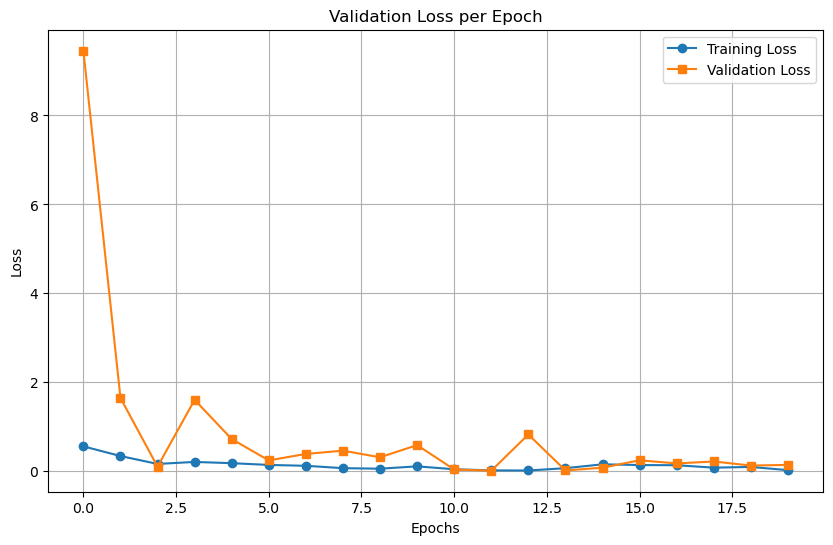

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_data, label='Training Loss', marker='o')
plt.plot(range(num_epochs), val_loss_data, label='Validation Loss', marker='s')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [89]:
# Function to perform inference on a single image
def infer(model, image_path, transform, device):
    # Load the image and convert it to RGB (3 channels)
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
    
    return predicted.item()

# Class names are based on the order printed from train_data.classes
class_names = ['birch', 'maple', 'pine', 'rowan', 'spruce']

# Path to the test image
image_path = 'test_data\pine\IMG-20241007-WA0017_jpg.rf.a2d4123d01a1dac6d5981c347ec459c9.jpg'  # Adjust the path as needed

# Run inference
predicted_class = infer(model, image_path, transform, device)
print(f'Predicted class: {class_names[predicted_class]}')

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Jamiv\AppData\Local\Temp\ipykernel_20432\413683719.py:20: SyntaxWarning: invalid escape sequence '\p'
  image_path = 'test_data\pine\IMG-20241007-WA0017_jpg.rf.a2d4123d01a1dac6d5981c347ec459c9.jpg'  # Adjust the path as needed


Predicted class: pine


## 9. Evaluating the Model with a Confusion Matrix

In this block, we generate predictions for the entire validation set and display a **confusion matrix** to better understand how well the model is performing on each tree class.

### Getting Predictions

The **`get_all_predictions()`** function:
- **`model.eval()`**: Sets the model to evaluation mode to disable training-specific features such as dropout.
- **Predictions**: For each batch in the validation loader, we pass the inputs through the model and record the predicted class labels.
    - The predictions are stored in **`all_preds`**, and the true labels in **`all_labels`**.
    - Both predictions and labels are moved back to the CPU using `.cpu()` and then converted to numpy arrays for further processing.
- **Concatenation**: After looping through the entire validation set, we concatenate the predictions and labels into single arrays for easy comparison.



Number of predictions: 51
Number of true labels: 51


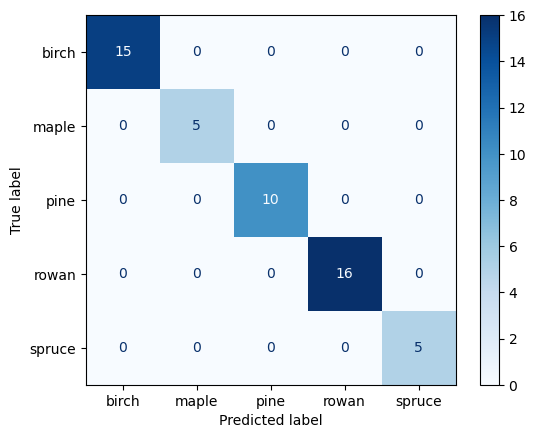

In [93]:
# Function to get predictions for the entire validation set
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert list of arrays to single numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Get predictions and true labels from validation data
preds, labels = get_all_predictions(model, val_loader, device)
# Print the shape of preds and labels
print(f"Number of predictions: {len(preds)}")
print(f"Number of true labels: {len(labels)}")
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Display the confusion matrix
class_names = ['birch', 'maple', 'pine', 'rowan', 'spruce']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Evaluating the model with test dataset
The dataset consists of self-taken pictures of each tree species
- Accuracy, precision, recall, and F1-score
- Confusion matrix

Accuracy: 0.9444
Precision: 0.9722
Recall: 0.9444
F1 Score: 0.9519


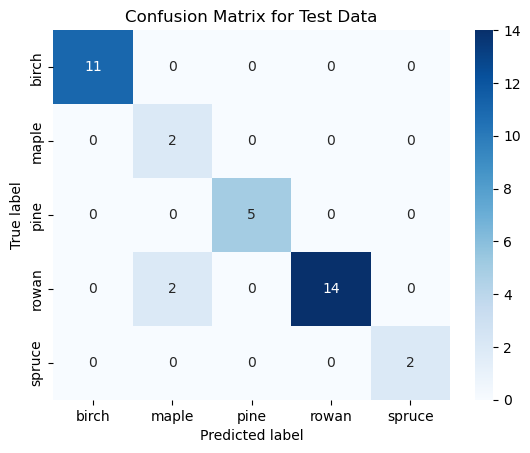

In [94]:
# Load the test dataset
test_data = ImageFolder(root='test_data', transform=transform)  # Adjust the path as needed
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


# Load the best model
model.eval()  # Set to evaluation mode

# Initialize lists to hold the true labels and predictions
true_labels = []
predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the appropriate device
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get the predicted class

        # Store true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
        predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # Use 'macro' or 'micro' if preferred
recall = recall_score(true_labels, predictions, average='weighted')  # Use 'macro' or 'micro' if preferred
f1 = f1_score(true_labels, predictions, average='weighted')  # Use 'macro' or 'micro' if preferred

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Class names (use the same order as in ImageFolder)
class_names = test_data.classes

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Test Data')
plt.show()

## 10. Inference on a Single Image and Logging Results to W&B

In this block, we define a function to perform inference on a single image using the pre-trained model and log the results to **Weights & Biases (W&B)**. This is useful for evaluating the model's performance on individual images and visualizing the results.

### Function: `infer_and_log()`

- **Loading and Preprocessing**: 
    - **`Image.open(image_path).convert('RGB')`**: Opens the image from the given path and converts it to an RGB format (3-channel).
    - **`transform(image)`**: Applies the transformation (e.g., resizing, tensor conversion) to the image, similar to how we transformed the training and validation images.
    - **`.unsqueeze(0)`**: Adds a batch dimension to the image tensor, as the model expects input in batches.
    - The image tensor is then moved to the specified device (GPU or CPU) using **`.to(device)`**.

- **Inference**:
    - **`model.eval()`**: The model is set to evaluation mode to disable any training-specific operations.
    - **`torch.no_grad()`**: Disables gradient calculations to save memory and speed up inference.
    - The model processes the image, and the predicted class is obtained by finding the index of the highest output score using **`.max(1)`**.
    - The predicted class is then mapped to its corresponding label using the **`class_names`** list.

- **Logging to Weights & Biases**:
    - **`wandb.log()`**: Logs the original input image along with the predicted class to **W&B** for easy tracking and visualization.
    - **`wandb.Image()`**: This function is used to log the input image along with a caption showing the predicted class.

### Example Usage

- **`class_names`**: The list of class names for the Rock, Paper, Scissors dataset (`['paper', 'rock', 'scissors']`).
- **Image Path**: The path to a test image (e.g., `'rps-test-set/rock/testrock01-00.png'`).
- **Inference and Logging**: The `infer_and_log()` function is called, which performs inference on the test image and logs the results to **W&B**.

The predicted class is then printed to the console to verify the result.

By using this function, you can easily evaluate the model's predictions on individual images and track those predictions through **Weights & Biases** for better analysis and visualization.


In [92]:
# Function to perform inference on a single image and log results to W&B
def infer_and_log(model, image_path, transform, device, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        predicted_class = class_names[predicted.item()]
    
    # Log the input image and the prediction to W&B
    wandb.log({
        "Image": wandb.Image(image, caption=f"Predicted: {predicted_class}"),
        "Prediction": predicted_class
    })

    return predicted_class

# Example usage
class_names = ['birch', 'maple', 'pine', 'rowan', 'spruce']

# Path to the test image
image_path = 'test_data\pine\IMG-20241007-WA0017_jpg.rf.a2d4123d01a1dac6d5981c347ec459c9.jpg'

# Run inference and log results to W&B
predicted_class = infer_and_log(model, image_path, transform, device, class_names)
print(f'Predicted class: {predicted_class}')


<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Jamiv\AppData\Local\Temp\ipykernel_20432\2885855318.py:28: SyntaxWarning: invalid escape sequence '\p'
  image_path = 'test_data\pine\IMG-20241007-WA0017_jpg.rf.a2d4123d01a1dac6d5981c347ec459c9.jpg'


Predicted class: pine


# Gradio Interface

In [95]:
# Function to perform inference on a single image
def infer_gradio(image):
    # Apply the same transform as used in training
    image = image.convert('RGB')  # Ensure it's in 3-channel format
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Put the model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
    
    return class_names[predicted.item()]  # Return the predicted class name

# Class names (modify according to your tree dataset classes)
class_names = ['birch', 'maple', 'pine', 'rowan', 'spruce']  # Example classes

# Gradio Interface
interface = gr.Interface(
    fn=infer_gradio,  # The function for inference
    inputs=gr.Image(type="pil"),  # Input: an image file
    outputs="text",  # Output: the predicted class name
    title="Tree Species Detection",  # Title of the app
    description="Upload an image of a tree, and the model will predict its species."
)

# Launch the interface
interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://70bc358a340e1505f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
